In [7]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Covid-19 detection using Respiratory Sounds

The following code summarises the process undertaken for COVID-19 detection using respiratory sounds with the help of Coswara dataset.

In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Visualisation libraries 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

## Sound Analysis Library 

import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read


#from pydub import AudioSegment
import IPython
import os
from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split

# Data Extraction

The path for the COSWARA data and the directory for data to be extracted is provided here. The same path will be used in the whole notebook afterwards.

In [9]:
PATH = os.getcwd()+'/'
PATH_EXTRACTED = PATH + 'Extracted_data/' 

In [10]:
df = pd.read_csv(PATH+'combined_data.csv')

In [11]:
df.columns

Index(['id', 'a', 'covid_status', 'record_date', 'ep', 'g', 'l_c', 'l_l',
       'l_s', 'rU', 'smoker', 'cold', 'ht', 'diabetes', 'cough', 'ctDate',
       'ctScan', 'ctScore', 'diarrhoea', 'fever', 'loss_of_smell', 'mp',
       'testType', 'test_date', 'test_status', 'um', 'vacc', 'bd',
       'others_resp', 'ftg', 'st', 'ihd', 'asthma', 'others_preexist', 'cld',
       'pneumonia'],
      dtype='object')

In [12]:
df.head()

id   a covid_status record_date ep       g  \
0  iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28      healthy  2020-04-23  y    male   
1  AxuYWBN0jFVLINCBqIW5aZmGCdu1  25      healthy  2020-04-20  y    male   
2  C5eIsssb9GSkaAgIfsHMHeR6fSh1  28      healthy  2020-04-24  y  female   
3  YjbEAECMBIaZKyfqOvWy5DDImUb2  26      healthy  2020-04-23  y    male   
4  aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32      healthy  2020-04-22  y    male   

             l_c              l_l             l_s rU  ... vacc   bd  \
0          India        Anantapur  Andhra Pradesh  n  ...  NaN  NaN   
1          India  BENGALURU URBAN       Karnataka  n  ...  NaN  NaN   
2  United States       Pittsburgh    Pennsylvania  n  ...  NaN  NaN   
3          India        Bangalore       Karnataka  n  ...  NaN  NaN   
4          India          Nalanda           Bihar  n  ...  NaN  NaN   

  others_resp  ftg   st  ihd asthma  others_preexist  cld pneumonia  
0         NaN  NaN  NaN  NaN    NaN              NaN  NaN       NaN  
1         NaN  NaN  NaN  NaN    NaN              NaN  NaN       NaN  
2         NaN  NaN  NaN  NaN    NaN              NaN  NaN       NaN  
3         NaN  NaN  NaN  NaN    NaN              NaN  NaN       NaN  
4         NaN  NaN  NaN  NaN    NaN              NaN  NaN       NaN  

[5 rows x 36 columns]

# Data Analysis and Processing

The COSWARA data contains the different features in <b>combined_data.csv</b> as well audio files for <i>breathing-deep, breathing-shallow, cough-heavy, cough-shallow, counting-fast, counting-normal, vowel-a, vowel-e, vowel-o</i>, corresponding to each user.

## Annotated data analysis

healthy                        1433
positive_mild                   426
no_resp_illness_exposed         248
positive_moderate               165
resp_illness_not_identified     157
recovered_full                  146
positive_asymp                   90
under_validation                 81
Name: covid_status, dtype: int64


<AxesSubplot: ylabel='covid_status'>

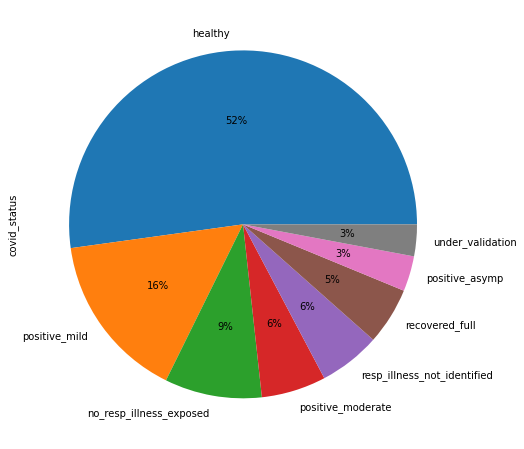

In [13]:
print(df['covid_status'].value_counts())
plt.figure(figsize=(16,8))
df['covid_status'].value_counts().plot(kind='pie', autopct='%1.0f%%')

<p>It can be seen from above that majority of the data is from healthy people or from those who have recovered from COVID. Only a small percentage of the data is positive and this might lead to a biased model.</p>
It is also of note that, few but significant number of people are under validation, which can be be removed based on other feature analysis.

blank 1413
p     681
na    314
n     257
ut     81
Name: test_status, dtype: int64


<AxesSubplot: ylabel='Test Status'>

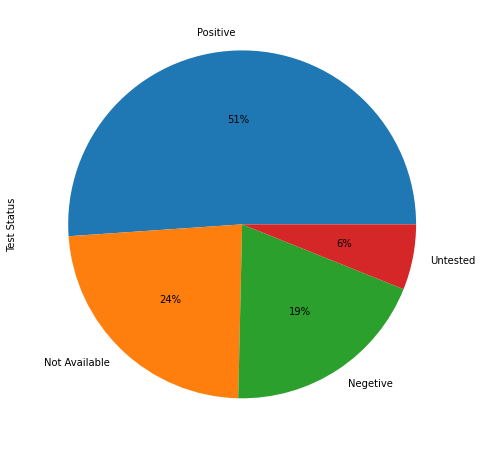

In [14]:
print('blank ' + str(df['test_status'].isna().sum()))
print(df['test_status'].value_counts())
plt.figure(figsize=(16,8))
df['test_status'].value_counts().plot(kind='pie', labels=['Positive', 'Not Available','Negetive','Untested'], ylabel='Test Status', autopct='%1.0f%%')

<p>It can be also be seen that majority of the test status data is blank. Of the values which are not blank a significant number is either not available or untested. This makes this feature not a good standalone candidate for classification.</p>
<b>We need to find a combination of features to determine the target variable for classification.</b>

## Target Label Generation

<p>We can broadly define the classification to binary classification as Covid and non-Covid (1 and 0 resp.), based on the features covid_status and test_status.</p> 
We can mark all the covid status positive labels as 1 as well as those labels which are tested positive but not have recovered covid status.

In [15]:
df['covid_test_status'] = (df['covid_status'].isin(["positive_asymp","positive_mild","positive_moderate"]) | 
                           (df['test_status'].isin(["p"]) & ~df['covid_status'].eq("recovered_full")))  * 1

In [16]:
df.groupby(['covid_test_status','covid_status']).agg({'id':'count'}).rename(columns={'id':'User Count'})

User Count
covid_test_status covid_status                           
0                 healthy                            1433
                  no_resp_illness_exposed             248
                  recovered_full                      146
                  resp_illness_not_identified         157
                  under_validation                     81
1                 positive_asymp                       90
                  positive_mild                       426
                  positive_moderate                   165

0    2065
1     681
Name: covid_test_status, dtype: int64


<AxesSubplot: xlabel='covid_test_status', ylabel='count'>

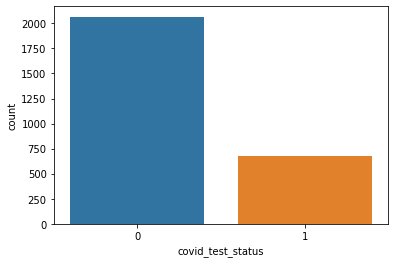

In [17]:
print(df['covid_test_status'].value_counts())
sns.countplot(x=df['covid_test_status'])

###  We can observe that the data is biased and this may result in creation of a biased model

In [18]:
symptom_list = ['asthma', 'smoker', 'ht', 'cold', 'diabetes', 'cough', 'diarrhoea', 'fever', 'loss_of_smell', 'mp', 'bd', 'others_resp', 'ftg', 'st', 'ihd', 'others_preexist', 'cld',
       'pneumonia']
label_list = ['asthma', 'smoker', 'hypertension', 'cold', 'diabetes', 'cough', 'diarrhoea', 'fever', 'loss_of_smell', 'muscle_pain', 'breathing_difficulties', 'others_resp', 'fatigue', 'sore_throat', 'ischemic_heart_disease', 'others_preexist', 'chronic_lung_disease',
       'pneumonia']
df[symptom_list].isnull().sum()

asthma             2612
smoker             1660
ht                 2513
cold               2258
diabetes           2514
cough              2094
diarrhoea          2694
fever              2340
loss_of_smell      2577
mp                 2421
bd                 2535
others_resp        2674
ftg                2364
st                 2450
ihd                2709
others_preexist    2646
cld                2702
pneumonia          2701
dtype: int64

In [19]:
df[symptom_list].nunique()

asthma             1
smoker             4
ht                 1
cold               1
diabetes           1
cough              1
diarrhoea          1
fever              1
loss_of_smell      1
mp                 1
bd                 1
others_resp        1
ftg                1
st                 1
ihd                1
others_preexist    1
cld                1
pneumonia          1
dtype: int64

A lot of data in the other symptom features are null and have different entries for label. Thus we cannot use these features reliably. We can still fill in the blank data and encode the different entries to a binary label.

In [20]:
df.fillna(dict.fromkeys(symptom_list, 0), inplace = True)
df[symptom_list] = df[symptom_list].replace({True: 1, 'True': 1, 'y': 1, 'False': 0, 'n': 0})

In [21]:
df[symptom_list].nunique()

asthma             2
smoker             2
ht                 2
cold               2
diabetes           2
cough              2
diarrhoea          2
fever              2
loss_of_smell      2
mp                 2
bd                 2
others_resp        2
ftg                2
st                 2
ihd                2
others_preexist    2
cld                2
pneumonia          2
dtype: int64

In [22]:
df.to_csv(PATH+'processed_data.csv', index=False)

In [23]:
df['record_date'] = df['record_date'].str.replace('-', '')

In [24]:
df.head()

id   a covid_status record_date ep       g  \
0  iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28      healthy    20200423  y    male   
1  AxuYWBN0jFVLINCBqIW5aZmGCdu1  25      healthy    20200420  y    male   
2  C5eIsssb9GSkaAgIfsHMHeR6fSh1  28      healthy    20200424  y  female   
3  YjbEAECMBIaZKyfqOvWy5DDImUb2  26      healthy    20200423  y    male   
4  aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32      healthy    20200422  y    male   

             l_c              l_l             l_s rU  ...  bd  others_resp  \
0          India        Anantapur  Andhra Pradesh  n  ...   0            0   
1          India  BENGALURU URBAN       Karnataka  n  ...   0            0   
2  United States       Pittsburgh    Pennsylvania  n  ...   0            0   
3          India        Bangalore       Karnataka  n  ...   0            0   
4          India          Nalanda           Bihar  n  ...   0            0   

   ftg  st  ihd asthma others_preexist  cld  pneumonia  covid_test_status  
0    0   0    0      0               0    0          0                  0  
1    0   0    0      0               0    0          0                  0  
2    0   0    0      0               0    0          0                  0  
3    0   0    0      0               0    0          0                  0  
4    0   0    0      0               0    0          0                  0  

[5 rows x 37 columns]

### We can now analyse the various properties of covid positive data

In [25]:
df_positive = df.loc[df['covid_test_status'] == 1]
df_positive

id   a       covid_status record_date ep  \
28    9hXEs9OejdVxG6JJGCyKQpqVvy43  67  positive_moderate    20210719  y   
33    XbOUJCUl8GWEpQpIRMvujDE1sTE2  57  positive_moderate    20210717  n   
34    Qcliznd3z1VdWmJOZh9nvlstTYv1  47  positive_moderate    20210717  y   
36    AutXsDVtEcVH9ZQ58NqDunDcqZv1  63      positive_mild    20210717  y   
37    dFtGnzYqh1NVAwQUQ3wkysqAe3n1  25     positive_asymp    20210729  y   
...                            ...  ..                ...         ... ..   
2741  333NjqA1TfZJuICEdXSkPhVz0LA3  48     positive_asymp    20210713  y   
2742  dpA0EeRrtJUeKJjEuf7BL0AeTJZ2  36      positive_mild    20210706  y   
2743  UXhG3vgoxkWtd4Meky1nm0sRgMV2  76      positive_mild    20210713  y   
2744  A5KW9PXraNgckln1gnNaJnX6DvB2  25  positive_moderate    20210701  y   
2745  iYwmYc9CdlSuzqGwIlXNWI6eFpm1  78      positive_mild    20210706  y   

           g    l_c              l_l         l_s rU  ...  bd  others_resp  \
28      male  India  Annur coimbator  Tamil Nadu  n  ...   0            0   
33    female  India       Coimbatore  Tamil Nadu  n  ...   0            0   
34      male  India       Coimbatore  Tamil Nadu  n  ...   0            0   
36    female  India            Erode  Tamil Nadu  n  ...   0            1   
37      male  India              NaN       Assam  n  ...   0            0   
...      ...    ...              ...         ... ..  ...  ..          ...   
2741    male  India     Thondamuthur  Tamil Nadu  n  ...   0            0   
2742    male  India            MSRMC   Karnataka  n  ...   0            0   
2743    male  India       Coimbatore  Tamil Nadu  n  ...   0            0   
2744    male  India       Coimbatore  Tamil Nadu  n  ...   0            0   
2745  female  India            Msrmc   Karnataka  n  ...   0            0   

      ftg  st  ihd asthma others_preexist  cld  pneumonia  covid_test_status  
28      0   0    0      0               0    0          0                  1  
33      0   0    0      0               0    0          0                  1  
34      1   0    0      0               0    0          0                  1  
36      1   0    1      0               0    0          0                  1  
37      0   0    0      0               0    0          0                  1  
...   ...  ..  ...    ...             ...  ...        ...                ...  
2741    1   0    0      0               0    0          0                  1  
2742    0   0    0      0               0    0          0                  1  
2743    1   0    0      0               0    0          0                  1  
2744    0   0    0      0               0    0          0                  1  
2745    1   0    0      0               0    0          0                  1  

[681 rows x 37 columns]

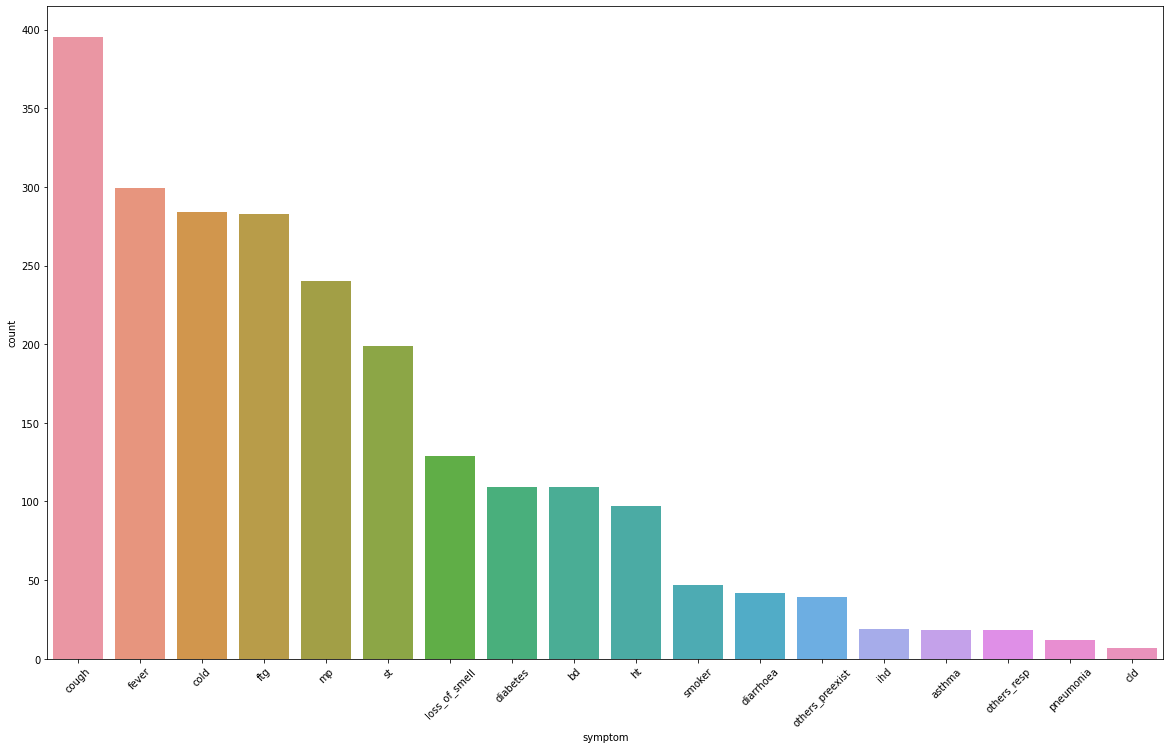

In [26]:

source = df_positive.agg(dict.fromkeys(symptom_list,'sum')).reset_index().rename(columns={'index':'symptom', 0:'count'})
source.sort_values('count', ascending=False, inplace=True)
plt.figure(figsize=(20,12))
label_plot = sns.barplot(source['symptom'], source['count'])
for item in label_plot.get_xticklabels():
    item.set_rotation(45)

#### Cough, Fever, Cold, Fatigue and Muscle Pain form the top symptoms in COVID positive patients.

This will be useful for model optimization in case we need to add extra features.

## Audio Data Analysis

We can get the audio files from the extracted data and add the file paths to the annotated features.

In [27]:
data_cols = ['breathing-deep', 'breathing-shallow', 'cough-heavy', 'cough-shallow', 'counting-fast', 'counting-normal', 'vowel-a', 'vowel-e', 'vowel-o']
df1 = pd.DataFrame(dict.fromkeys(data_cols, np.nan), data_cols)
df = df.join(df1)
for col in tqdm(data_cols):
    for i in range(len(df)):
        filepath = PATH_EXTRACTED+df['record_date'][i]+'/'+df['id'][i]+'/'+col+'.wav'
        if (os.path.exists(filepath)):
            df[col][i] = filepath


100%|██████████| 9/9 [00:00<00:00, 26.92it/s]


In [28]:
for col in data_cols:
    print(col + ' = {}'.format(df[col].notna().sum()))

breathing-deep = 587
breathing-shallow = 587
cough-heavy = 587
cough-shallow = 587
counting-fast = 587
counting-normal = 587
vowel-a = 587
vowel-e = 587
vowel-o = 587


Note: We have only a section of the total data that has audio samples. This might be because of the corrupted data from the database or some issue with the extraction process. We need to address this problem while optimizination.

In [29]:
df.to_csv(os.getcwd()+'/processed_data.csv', index=False)

In [30]:
df_positive = df.loc[df['covid_test_status'] == 1]
df_positive

id   a       covid_status record_date ep  \
28    9hXEs9OejdVxG6JJGCyKQpqVvy43  67  positive_moderate    20210719  y   
33    XbOUJCUl8GWEpQpIRMvujDE1sTE2  57  positive_moderate    20210717  n   
34    Qcliznd3z1VdWmJOZh9nvlstTYv1  47  positive_moderate    20210717  y   
36    AutXsDVtEcVH9ZQ58NqDunDcqZv1  63      positive_mild    20210717  y   
37    dFtGnzYqh1NVAwQUQ3wkysqAe3n1  25     positive_asymp    20210729  y   
...                            ...  ..                ...         ... ..   
2741  333NjqA1TfZJuICEdXSkPhVz0LA3  48     positive_asymp    20210713  y   
2742  dpA0EeRrtJUeKJjEuf7BL0AeTJZ2  36      positive_mild    20210706  y   
2743  UXhG3vgoxkWtd4Meky1nm0sRgMV2  76      positive_mild    20210713  y   
2744  A5KW9PXraNgckln1gnNaJnX6DvB2  25  positive_moderate    20210701  y   
2745  iYwmYc9CdlSuzqGwIlXNWI6eFpm1  78      positive_mild    20210706  y   

           g    l_c              l_l         l_s rU  ...  covid_test_status  \
28      male  India  Annur coimbator  Tamil Nadu  n  ...                  1   
33    female  India       Coimbatore  Tamil Nadu  n  ...                  1   
34      male  India       Coimbatore  Tamil Nadu  n  ...                  1   
36    female  India            Erode  Tamil Nadu  n  ...                  1   
37      male  India              NaN       Assam  n  ...                  1   
...      ...    ...              ...         ... ..  ...                ...   
2741    male  India     Thondamuthur  Tamil Nadu  n  ...                  1   
2742    male  India            MSRMC   Karnataka  n  ...                  1   
2743    male  India       Coimbatore  Tamil Nadu  n  ...                  1   
2744    male  India       Coimbatore  Tamil Nadu  n  ...                  1   
2745  female  India            Msrmc   Karnataka  n  ...                  1   

      breathing-deep  breathing-shallow  cough-heavy  cough-shallow  \
28               NaN                NaN          NaN            NaN   
33               NaN                NaN          NaN            NaN   
34               NaN                NaN          NaN            NaN   
36               NaN                NaN          NaN            NaN   
37               NaN                NaN          NaN            NaN   
...              ...                ...          ...            ...   
2741             NaN                NaN          NaN            NaN   
2742             NaN                NaN          NaN            NaN   
2743             NaN                NaN          NaN            NaN   
2744             NaN                NaN          NaN            NaN   
2745             NaN                NaN          NaN            NaN   

     counting-fast counting-normal  vowel-a  vowel-e  vowel-o  
28             NaN             NaN      NaN      NaN      NaN  
33             NaN             NaN      NaN      NaN      NaN  
34             NaN             NaN      NaN      NaN      NaN  
36             NaN             NaN      NaN      NaN      NaN  
37             NaN             NaN      NaN      NaN      NaN  
...            ...             ...      ...      ...      ...  
2741           NaN             NaN      NaN      NaN      NaN  
2742           NaN             NaN      NaN      NaN      NaN  
2743           NaN             NaN      NaN      NaN      NaN  
2744           NaN             NaN      NaN      NaN      NaN  
2745           NaN             NaN      NaN      NaN      NaN  

[681 rows x 46 columns]

In [31]:
df_negative = df.loc[df['covid_test_status'] == 0]
df_negative

id   a             covid_status record_date  \
0     iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28                  healthy    20200423   
1     AxuYWBN0jFVLINCBqIW5aZmGCdu1  25                  healthy    20200420   
2     C5eIsssb9GSkaAgIfsHMHeR6fSh1  28                  healthy    20200424   
3     YjbEAECMBIaZKyfqOvWy5DDImUb2  26                  healthy    20200423   
4     aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32                  healthy    20200422   
...                            ...  ..                      ...         ...   
2722  YXt9ERhtqqhCsrni0y61UNue3Yy2  22  no_resp_illness_exposed    20210713   
2728  AHP17rlsWyNnz73hrGbeMspbun03  38           recovered_full    20210713   
2731  gGgG540lBOZoSK1vyqNVlqBzQBl1  20                  healthy    20210712   
2733  nx6RCgD0OjdzLa07UHBdHfz54ML2  24                  healthy    20210713   
2739  J2KBR20S1lOfFS2iA7UyuOBOmgq1  32  no_resp_illness_exposed    20210704   

     ep       g            l_c              l_l             l_s rU  ...  \
0     y    male          India        Anantapur  Andhra Pradesh  n  ...   
1     y    male          India  BENGALURU URBAN       Karnataka  n  ...   
2     y  female  United States       Pittsburgh    Pennsylvania  n  ...   
3     y    male          India        Bangalore       Karnataka  n  ...   
4     y    male          India          Nalanda           Bihar  n  ...   
...  ..     ...            ...              ...             ... ..  ...   
2722  y  female          India       Coimbatore      Tamil Nadu  n  ...   
2728  y    male          India       Coimbatore      Tamil Nadu  n  ...   
2731  y    male          India              NaN       Karnataka  n  ...   
2733  y  female  United States              NaN      California  n  ...   
2739  y    male          India            vizag  Andhra Pradesh  y  ...   

      covid_test_status                                     breathing-deep  \
0                     0                                                NaN   
1                     0                                                NaN   
2                     0  /Users/priyadarshanipriya/Downloads/Coswara/Co...   
3                     0                                                NaN   
4                     0                                                NaN   
...                 ...                                                ...   
2722                  0                                                NaN   
2728                  0                                                NaN   
2731                  0                                                NaN   
2733                  0                                                NaN   
2739                  0                                                NaN   

                                      breathing-shallow  \
0                                                   NaN   
1                                                   NaN   
2     /Users/priyadarshanipriya/Downloads/Coswara/Co...   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
2722                                                NaN   
2728                                                NaN   
2731                                                NaN   
2733                                                NaN   
2739                                                NaN   

                                            cough-heavy  \
0                                                   NaN   
1                                                   NaN   
2     /Users/priyadarshanipriya/Downloads/Coswara/Co...   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
2722                                                NaN   
2728                                                NaN   
2731 

## Spectral difference of a Covid and Non-Covid user

In [32]:
def Spectromter_multiple_fft(data_file_path,Test_type):
    test_wav = librosa.core.load(data_file_path, sr=44100)[0]
    fig, ax = plt.subplots(5, 1, figsize=(20,18))
    ax[0].plot(test_wav)
    ax[0].set_title(f"Full "+Test_type+" waveform")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[1].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[1].set_title(f"Slice of {Test_type} mel spectrogram 512 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=1024, hop_length=256, win_length=1024, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[2].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[2].set_title(f"Slice of {Test_type} mel spectrogram 1024 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[3].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[3].set_title(f"Slice of {Test_type} mel spectrogram 2048 fft")
    
    chroma = librosa.feature.chroma_stft(test_wav, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann')
    ax[4].imshow(chroma[:,:1000], origin='lower')
    ax[4].set_title(f"Slice of {Test_type} chromagram 2048 fft")

### We'll compare multiple fft spectral using cough heavy samples of a female from both covid positive and non-covid user each.

In [33]:
cough_heavy_pos = df_positive['cough-heavy'].dropna()
cough_heavy_pos.head()

333    /Users/priyadarshanipriya/Downloads/Coswara/Co...
373    /Users/priyadarshanipriya/Downloads/Coswara/Co...
515    /Users/priyadarshanipriya/Downloads/Coswara/Co...
522    /Users/priyadarshanipriya/Downloads/Coswara/Co...
539    /Users/priyadarshanipriya/Downloads/Coswara/Co...
Name: cough-heavy, dtype: object

In [34]:
df_positive.loc[539]['g']

'female'

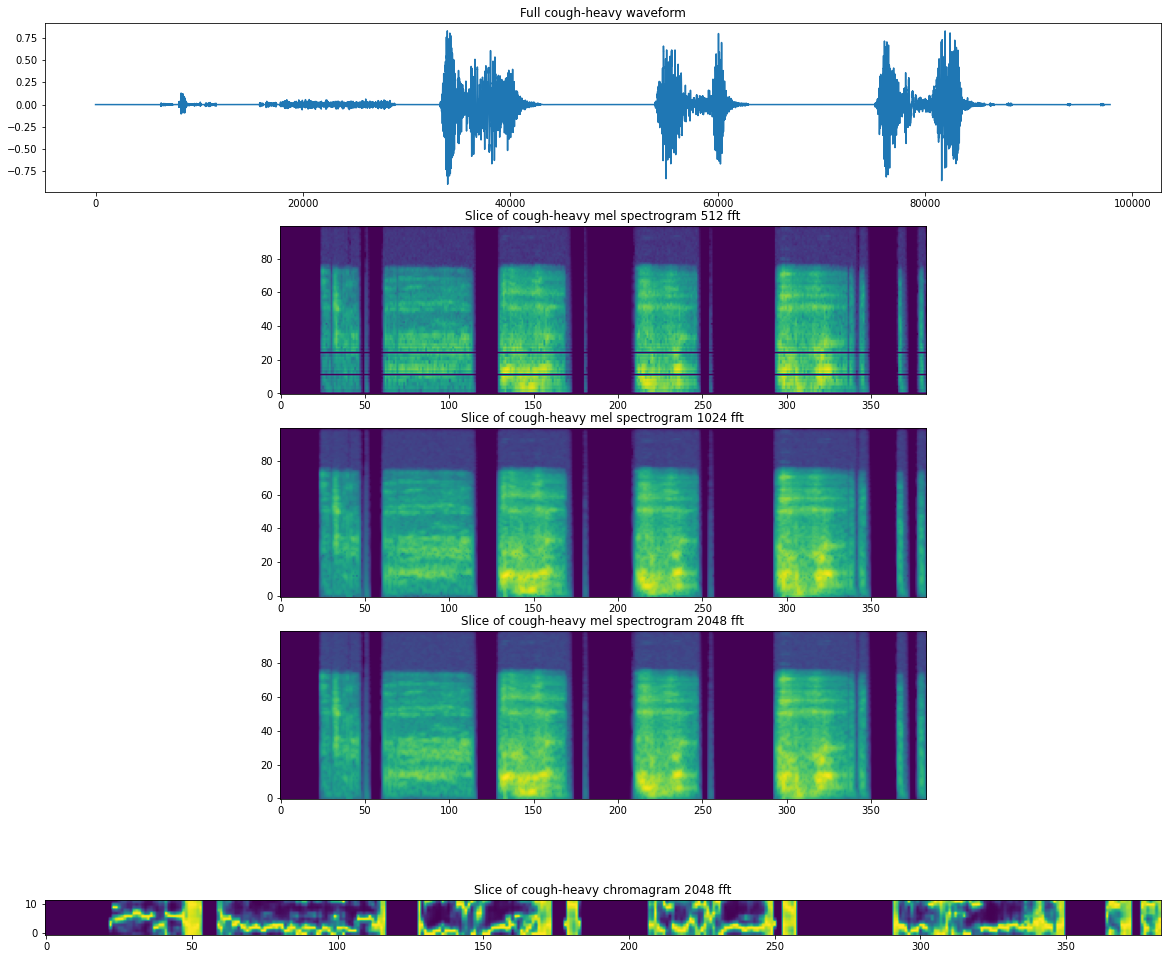

In [35]:
path = cough_heavy_pos[539]
Spectromter_multiple_fft(data_file_path=path,Test_type='cough-heavy')
ipd.Audio(path)

In [36]:
cough_heavy_neg = df_negative['cough-heavy'].dropna()
cough_heavy_neg.head()

2     /Users/priyadarshanipriya/Downloads/Coswara/Co...
11    /Users/priyadarshanipriya/Downloads/Coswara/Co...
13    /Users/priyadarshanipriya/Downloads/Coswara/Co...
14    /Users/priyadarshanipriya/Downloads/Coswara/Co...
19    /Users/priyadarshanipriya/Downloads/Coswara/Co...
Name: cough-heavy, dtype: object

In [37]:
df_negative.loc[2650]['g']

'female'

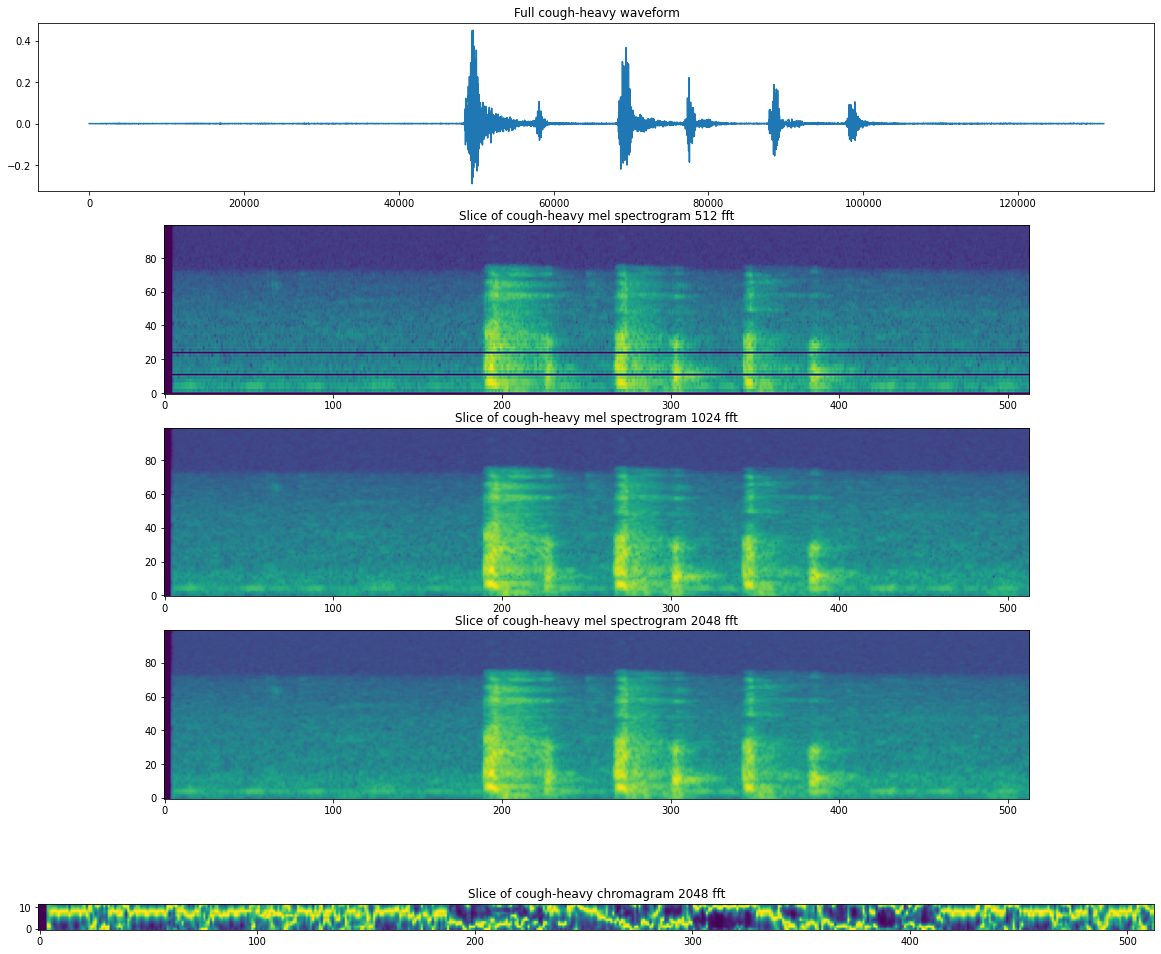

In [38]:
path = cough_heavy_neg[2650]
Spectromter_multiple_fft(data_file_path=path,Test_type='cough-heavy')
ipd.Audio(path)

### We'll compare spectrogram using all audio samples of a female from both covid positive and non-covid user each.

In [39]:
def get_spectogram(audio_file):
    time_series, sample_rate = librosa.load(audio_file)
    stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))
    return librosa.amplitude_to_db(stft, ref=np.max)

In [40]:
def plot_spectral_difference(resp_test_type,tgt_0_id,tgt_1_id):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))

    librosa.display.specshow(get_spectogram(df_negative[resp_test_type][tgt_0_id]),
                             y_axis='log', x_axis='time', ax=ax[0])
    ax[0].set(title=resp_test_type+' - Non COVID User')
    ax[0].label_outer()

    librosa.display.specshow(get_spectogram(df_positive[resp_test_type][tgt_1_id]),
                             y_axis='log', x_axis='time', ax=ax[1])

    ax[1].set(title=resp_test_type+' - COVID User')
    ax[1].label_outer();
    plt.suptitle('Recording for '+resp_test_type+' for COVID 19 User vs Non COVID User', fontsize=20)
    return None

100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


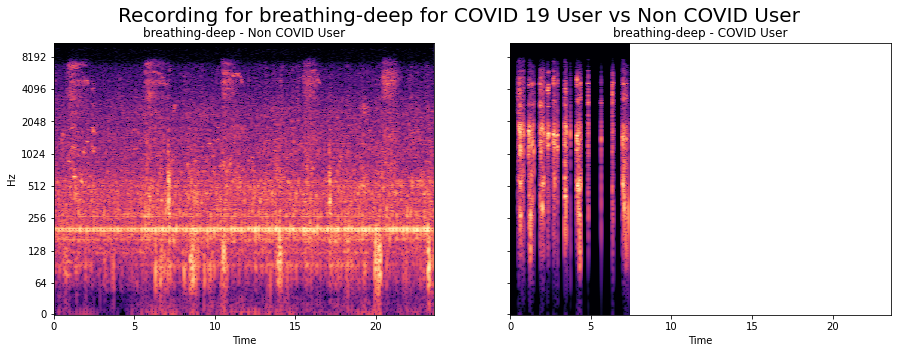

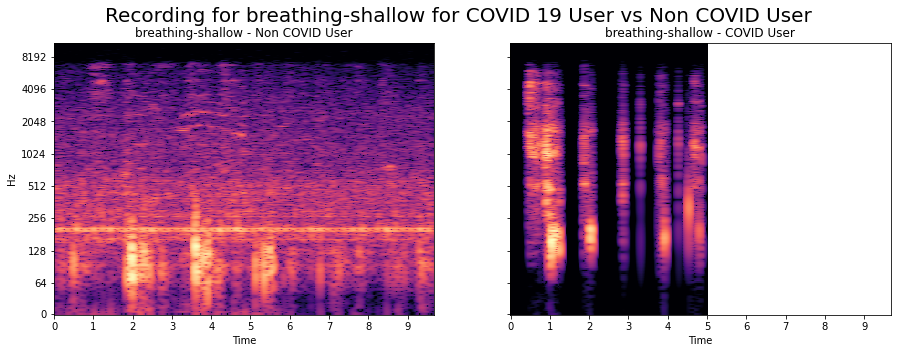

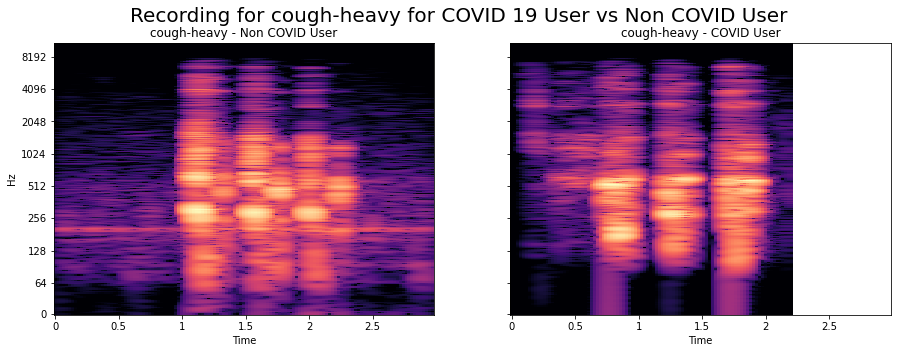

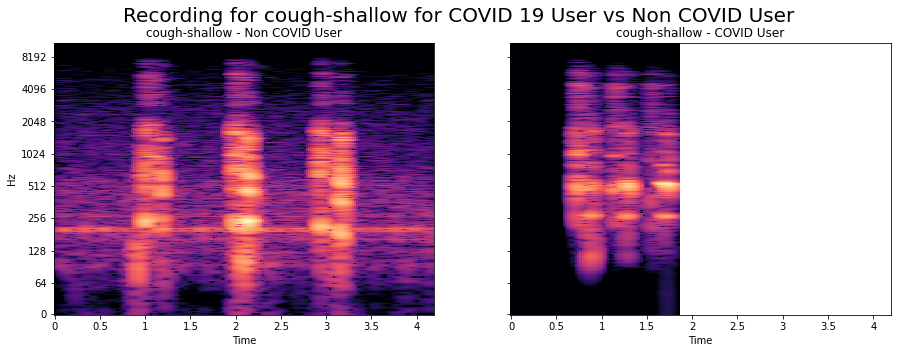

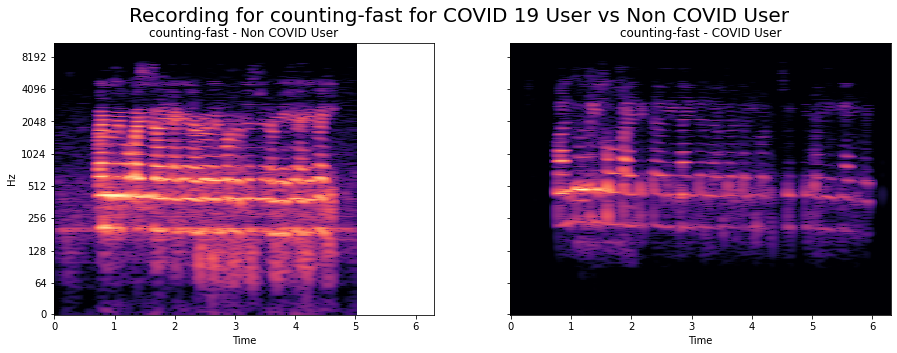

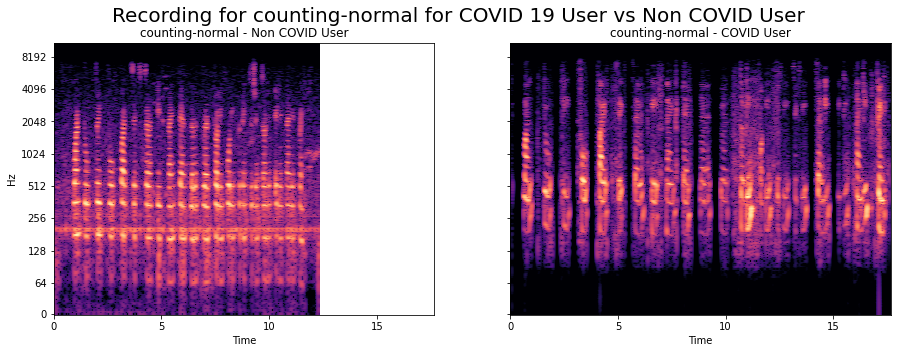

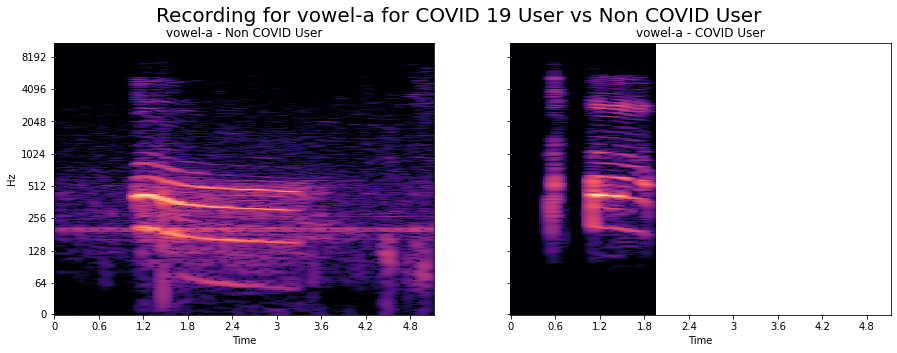

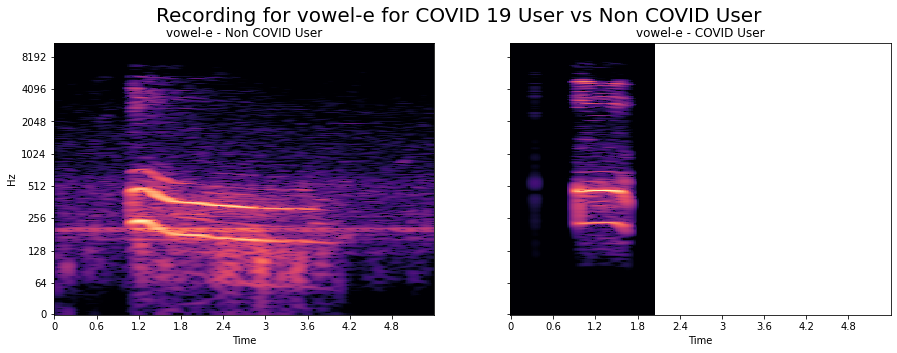

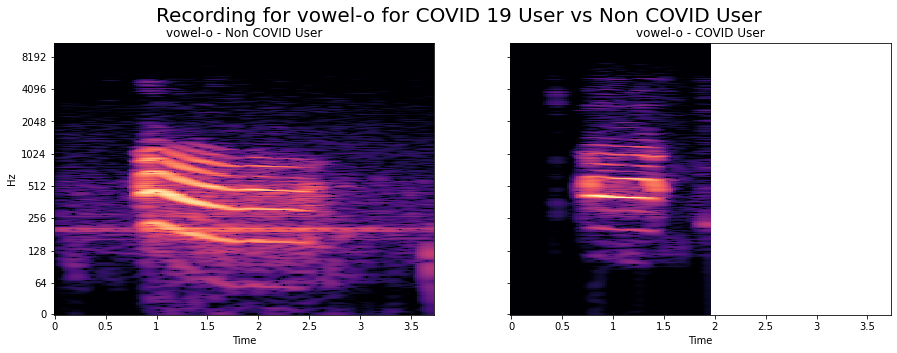

In [41]:
for tst in tqdm(data_cols):
    plot_spectral_difference(resp_test_type=tst,tgt_0_id=2650,tgt_1_id=539)

## Running audio analysis

We will use these audio samples to create a binary classification problem. We will extract the MFCC(Mel frequency cofficients) features from the sound samples and run a deep learning model to classify based on labels.

For this we will create a separate dataframe with audio paths and its repective labels as columns.

In [42]:
audio_df = pd.DataFrame(columns=['audio','label'])
for col in tqdm(data_cols):
    for i in range(len(df)):
        append_list = [df[col][i], df['covid_test_status'][i]]
        audio_df.loc[len(audio_df),:] = append_list
audio_df = audio_df.dropna()   
audio_df = audio_df.reset_index()
audio_df

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


index                                              audio label
0         2  /Users/priyadarshanipriya/Downloads/Coswara/Co...     0
1        11  /Users/priyadarshanipriya/Downloads/Coswara/Co...     0
2        13  /Users/priyadarshanipriya/Downloads/Coswara/Co...     0
3        14  /Users/priyadarshanipriya/Downloads/Coswara/Co...     0
4        19  /Users/priyadarshanipriya/Downloads/Coswara/Co...     0
...     ...                                                ...   ...
5278  24680  /Users/priyadarshanipriya/Downloads/Coswara/Co...     1
5279  24683  /Users/priyadarshanipriya/Downloads/Coswara/Co...     1
5280  24688  /Users/priyadarshanipriya/Downloads/Coswara/Co...     1
5281  24706  /Users/priyadarshanipriya/Downloads/Coswara/Co...     1
5282  24708  /Users/priyadarshanipriya/Downloads/Coswara/Co...     1

[5283 rows x 3 columns]

0    4608
1     675
Name: label, dtype: int64

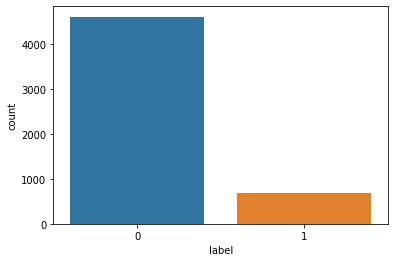

In [43]:
sns.countplot(x=audio_df['label'])
audio_df['label'].value_counts()

As is the trend we can see that we have a lot more samples for non-Covid persons than Covid persons.

We'll now generate the MFCC coefficients using the audio samples. Below is an example of cofficoent generation.

In [44]:
audio,sample_rate = librosa.load(audio_df['audio'][0])
mfccs = librosa.feature.mfcc(y=audio)
mfccs.shape

(20, 846)

We can now run the same function on all the samples.

In [45]:
import warnings
warnings.filterwarnings('ignore')

def extract_features(file):
    try:
        audio,sample_rate = librosa.load(file)
        mfccs = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
        mfcc_scaled = np.mean(mfccs.T,axis=0)
        return mfcc_scaled
    except:
        return 'failed'

In [46]:
extracted_features=[]
for i in trange(len(audio_df)):
    data = extract_features(audio_df['audio'][i])
    if data!='failed':
        label = audio_df['label'][i]
        extracted_features.append([data,label])

100%|██████████| 5283/5283 [19:28<00:00,  4.52it/s]  


In [47]:
features = pd.DataFrame(extracted_features,columns=['data','label'])

In [48]:
features

data  label
0     [-619.2041, 24.183672, 9.80098, 20.07123, 1.43...      0
1     [-879.4319, 16.627895, 5.1515846, 10.302308, 1...      0
2     [-530.2957, 34.34047, -29.351059, 20.604212, -...      0
3     [-528.99536, 27.931171, -28.829788, 48.698765,...      0
4     [-412.9803, 110.52773, -78.116234, -13.421739,...      0
...                                                 ...    ...
5183  [-692.61475, 52.229588, 23.817163, 5.647036, -...      1
5184  [-441.1343, 77.262535, 33.121628, 20.17052, -1...      1
5185  [-380.1655, 92.92098, -2.7055693, 8.165904, -4...      1
5186  [-470.75922, 21.77312, 12.625552, 6.237431, -2...      1
5187  [-533.07214, 99.14143, 40.59241, 16.097158, -2...      1

[5188 rows x 2 columns]

In [49]:
features.to_csv(os.getcwd()+'/extracted_features.csv')

# Train/Test data splitting

We will now use the MFCC extracted feature dataframe to run our classification model. We'll split our dataset into train and test with 30% as test data.

In [50]:
X=np.array(features['data'].tolist())
y=np.array(features['label'].tolist())

In [51]:
X.shape

(5188, 40)

In [52]:
y.shape

(5188,)

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y,random_state=0)

In [54]:
X_train.shape

(3631, 40)

In [55]:
y_train.shape

(3631,)

In [56]:
features['label'].value_counts()

0    4514
1     674
Name: label, dtype: int64

### Oversampling using SMOTE

In [71]:
from imblearn.over_sampling import SMOTE

In [72]:
os = SMOTE()
X_sm, Y_sm = os.fit_resample(X_train, pd.DataFrame(y_train))
print(f'''shape of X before SMOTE: {X_train.shape} 
shape of X after SMOTE: {X_sm.shape}''')
print('balanced class (%):')
Y_sm.value_counts(normalize=True) * 100

shape of X before SMOTE: (3631, 40) 
shape of X after SMOTE: (6318, 40)
balanced class (%):


0    50.0
1    50.0
dtype: float64

In [334]:
X_sm

array([[-3.8554388e+02,  6.7964211e+01, -6.9474740e+00, ...,
        -1.5504771e+00,  5.3295469e-01, -1.2439259e+00],
       [-3.8887027e+02,  8.6233437e+01, -2.5363152e+01, ...,
        -7.8637052e-01, -1.4027520e+00, -1.0192242e+00],
       [-4.3878381e+02,  3.5530560e+01, -1.2113340e+01, ...,
        -9.7464865e-01,  4.5434925e-01, -1.0333045e+00],
       ...,
       [-1.1309069e+03,  1.8533368e-01, -4.7058854e-03, ...,
        -3.7611299e-03, -3.7397940e-03, -4.8668796e-04],
       [-3.3258963e+02,  7.1241585e+01, -1.7473396e+01, ...,
        -9.4978637e-01, -1.8963937e+00,  2.7380511e-01],
       [-4.5008322e+02,  4.7074203e+01, -1.7330473e+01, ...,
        -2.4453839e-02,  5.8919489e-01, -1.5728102e+00]], dtype=float32)

# Model creation

We have chosen a Sequntial model here with 3 dense layers and one output layer.

In [244]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn import metrics

In [306]:
model=Sequential()
###first layer
model.add(Dense(128,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.3))

#output layer
model.add(Dense(1,activation='sigmoid'))

#compiling
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [307]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 128)               5248      
                                                                 
 activation_73 (Activation)  (None, 128)               0         
                                                                 
 dropout_99 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                8256      
                                                                 
 activation_74 (Activation)  (None, 64)                0         
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                                                                 
 dense_143 (Dense)           (None, 32)              

In [308]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=70)
model.fit(x=X_sm,y=Y_sm,validation_data=(X_test,y_test),callbacks=[es], batch_size=100,
         epochs=100)

Epoch 1/100


2022-10-16 10:55:04.420438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 4.7663 - accuracy: 0.5049

2022-10-16 10:55:05.442793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 16ms/step - loss: 4.7663 - accuracy: 0.5049 - val_loss: 0.8599 - val_accuracy: 0.2068
Epoch 2/100
64/64 [==============================] - 0s 7ms/step - loss: 0.9050 - accuracy: 0.5180 - val_loss: 0.7999 - val_accuracy: 0.1342
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7717 - accuracy: 0.5302 - val_loss: 0.7207 - val_accuracy: 0.2113
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7182 - accuracy: 0.5211 - val_loss: 0.7059 - val_accuracy: 0.1625
Epoch 5/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7084 - accuracy: 0.5150 - val_loss: 0.7014 - val_accuracy: 0.1676
Epoch 6/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7109 - accuracy: 0.5171 - val_loss: 0.7389 - val_accuracy: 0.1304
Epoch 7/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7042 - accuracy: 0.5147 - val_loss: 0.7062 - val_accuracy: 0.1503
Epoch 8/100
64/64 [=====

Epoch 59/100
64/64 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.7784 - val_loss: 0.7660 - val_accuracy: 0.5787
Epoch 60/100
64/64 [==============================] - 0s 6ms/step - loss: 0.5036 - accuracy: 0.7615 - val_loss: 0.6831 - val_accuracy: 0.5954
Epoch 61/100
64/64 [==============================] - 0s 6ms/step - loss: 0.4748 - accuracy: 0.7795 - val_loss: 0.7530 - val_accuracy: 0.5755
Epoch 62/100
64/64 [==============================] - 0s 6ms/step - loss: 0.4776 - accuracy: 0.7765 - val_loss: 0.6076 - val_accuracy: 0.6519
Epoch 63/100
64/64 [==============================] - 0s 6ms/step - loss: 0.4665 - accuracy: 0.7844 - val_loss: 0.7625 - val_accuracy: 0.5607
Epoch 64/100
64/64 [==============================] - 0s 6ms/step - loss: 0.4719 - accuracy: 0.7828 - val_loss: 0.6278 - val_accuracy: 0.6378
Epoch 65/100
64/64 [==============================] - 0s 5ms/step - loss: 0.4596 - accuracy: 0.7866 - val_loss: 0.6176 - val_accuracy: 0.6493
Epoch 

In [309]:
mod= pd.DataFrame(model.history.history)
mod

loss  accuracy  val_loss  val_accuracy
0   4.766324  0.504907  0.859917      0.206808
1   0.905029  0.518044  0.799866      0.134233
2   0.771692  0.530231  0.720686      0.211304
3   0.718208  0.521051  0.705855      0.162492
4   0.708384  0.515036  0.701365      0.167630
..       ...       ...       ...           ...
95  0.372909  0.837132  0.575902      0.678870
96  0.372327  0.831909  0.547960      0.736031
97  0.362226  0.838082  0.528834      0.760437
98  0.365258  0.839823  0.555093      0.755299
99  0.366653  0.840456  0.533244      0.763648

[100 rows x 4 columns]

<AxesSubplot: >

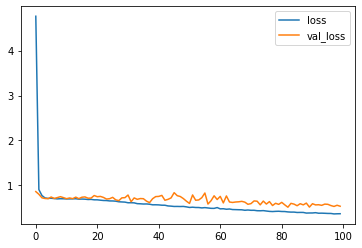

In [310]:
mod[['loss','val_loss']].plot()

<AxesSubplot: >

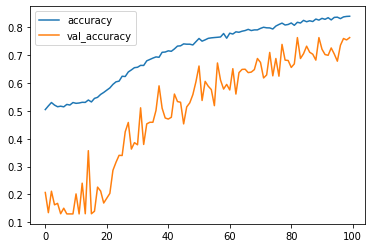

In [311]:
mod[['accuracy','val_accuracy']].plot()

# Model Performance

We can now calculate the model performance by calculating recall and f1-score and drawing up a confusion matrix.

In [324]:
pred = model.predict(X_test)
reshaped = pred.reshape((1557,))
T=0.7
y_pred_bool = reshaped>=T

49/49 [==============================] - 0s 2ms/step


In [325]:
from sklearn.metrics import classification_report,confusion_matrix, fbeta_score

In [326]:
y_test.shape
print(classification_report(y_test,y_pred_bool))
print('fβ score    '+str(fbeta_score(y_test, y_pred_bool, beta=2, average='binary')))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1355
           1       0.37      0.44      0.40       202

    accuracy                           0.83      1557
   macro avg       0.64      0.66      0.65      1557
weighted avg       0.84      0.83      0.84      1557

fβ score    0.421455938697318


In [216]:
pred.shape
reshaped = pred.reshape((1557,))
reshaped.shape

(1557,)

In [217]:
confusion_matrix(y_test,y_pred_bool)

array([[1038,  317],
       [  86,  116]])

The model is highly overfitting and needss to be optimized. This can be done by augmenting the data for positive class to reduce the bias. 

In [327]:
import pickle

In [328]:
# save the model to disk
filename = 'covid_sound_model_1.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://e9c2375f-18c2-49c6-b1bb-a62f814d6575/assets
